In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz 

In [2]:
!tar -xvf spark-3.2.1-bin-hadoop3.2.tgz

spark-3.2.1-bin-hadoop3.2/
spark-3.2.1-bin-hadoop3.2/LICENSE
spark-3.2.1-bin-hadoop3.2/NOTICE
spark-3.2.1-bin-hadoop3.2/R/
spark-3.2.1-bin-hadoop3.2/R/lib/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/DESCRIPTION
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/INDEX
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/Rd.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/features.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/hsearch.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/links.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/nsInfo.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/package.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/vignette.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/NAMESPACE
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/SparkR
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/SparkR.rdb
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/SparkR.rdx
spark-3.2.1-bin-hadoop3.2/R/lib/Sp

In [4]:
!pip install pyspark
!pip install -q findspark

     |████████████████████████████████| 281.4 MB 17 kB/s 
     |████████████████████████████████| 198 kB 43.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=e0b7746987f17cd84e5a32c8dcb12fe88a2be681b90327e0cded77d6089c7e25
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [5]:
#Ismet Okan Celik CWID:10472265
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import os 
import findspark
from google.colab import drive
from google.colab import files

In [6]:
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]="spark-3.2.1-bin-hadoop3.2/"

In [8]:
findspark.init()
from pyspark.sql import SparkSession 

spark = SparkSession.builder.master("local[*]").getOrCreate()

# training = spark.read.option("delimiter", "|").csv('trainItem.data')
# training.show(5)

training = spark.read.csv("re_u.data", header = False)
training.show(5)

+---+---+---+
|_c0|_c1|_c2|
+---+---+---+
|196|242|  3|
|186|302|  3|
| 22|377|  1|
|244| 51|  2|
|166|346|  1|
+---+---+---+
only showing top 5 rows



In [9]:
training = training.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "itemID").withColumnRenamed("_c2", "rating")
training.show(5)

+------+------+------+
|userID|itemID|rating|
+------+------+------+
|   196|   242|     3|
|   186|   302|     3|
|    22|   377|     1|
|   244|    51|     2|
|   166|   346|     1|
+------+------+------+
only showing top 5 rows



In [10]:
from pyspark.sql.types import IntegerType
training = training.withColumn("userID", training["userID"].cast(IntegerType()))
training = training.withColumn("itemID", training["itemID"].cast(IntegerType()))
training = training.withColumn("rating", training["rating"].cast('float'))
training.show(3)

+------+------+------+
|userID|itemID|rating|
+------+------+------+
|   196|   242|   3.0|
|   186|   302|   3.0|
|    22|   377|   1.0|
+------+------+------+
only showing top 3 rows



In [34]:
testing = spark.read.csv("re_u.data", header = False)

In [35]:
testing = testing.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "itemID").withColumnRenamed("_c2", "rating")
testing.show(5)

+------+------+------+
|userID|itemID|rating|
+------+------+------+
|   196|   242|     3|
|   186|   302|     3|
|    22|   377|     1|
|   244|    51|     2|
|   166|   346|     1|
+------+------+------+
only showing top 5 rows



In [53]:
testing = testing.withColumn("userID", testing["userID"].cast(IntegerType()))
testing = testing.withColumn("itemID", testing["itemID"].cast(IntegerType()))
testing = testing.withColumn("rating", testing["rating"].cast('float'))
testing.show(3)

+------+------+------+
|userID|itemID|rating|
+------+------+------+
|   196|   242|   3.0|
|   186|   302|   3.0|
|    22|   377|   1.0|
+------+------+------+
only showing top 3 rows



In [135]:
def prediction_values(iteration,ranking,datasize):
  als = ALS(
        maxIter=iteration, 
        rank = ranking,
        regParam=0.01,
        userCol="userID", 
        itemCol="itemID",
        ratingCol="rating", 
        nonnegative = True, 
        implicitPrefs = False,
        coldStartStrategy="drop"
    )

  model = als.fit(training)

  predictions = model.transform(testing)
  prediction_val=predictions.take(datasize)
  return prediction_val

In [139]:
'''1.   For the provided data file "re_u.data", fix the "maxIter=20" and use different "rank" size,  
rank=5, 7, 10, 20 and test the MSE values.''' 
datasize=100000
iteration=20
rank_list=[5, 7, 10, 20]
Mean_Square_Error_Q1=[]
for k in rank_list:
  prediction_val=prediction_values(iteration,k,datasize)

  total=[]
  for i in range(len(prediction_val)):
    error=(prediction_val[i][2]-prediction_val[i][3])**2
    total.append(error)
  mean_squared_error=np.sum(total)/len(total)
  print('Mean Square Error(rank='+str(k)+')=',mean_squared_error)
  Mean_Square_Error_Q1.append(mean_squared_error)

Mean Square Error(rank=5)= 0.6291142273188446
Mean Square Error(rank=7)= 0.5711578245877916
Mean Square Error(rank=10)= 0.5121842386913468
Mean Square Error(rank=20)= 0.35947429394119595


In [140]:
'''2.   For the fixed "rank=20", and use different maxIter=2, 5,10, 20 
and test the MSE values.
'''
datasize=100000
ranking=20
iteration_list=[2, 5,10, 20]
Mean_Square_Error_Q2=[]
for k in iteration_list:
  prediction_val=prediction_values(k,ranking,datasize)

  total=[]
  for i in range(len(prediction_val)):
    error=(prediction_val[i][2]-prediction_val[i][3])**2
    total.append(error)
  mean_squared_error=np.sum(total)/len(total)
  print('Mean Square Error(maxIter='+str(k)+')=',mean_squared_error)
  Mean_Square_Error_Q2.append(mean_squared_error)

Mean Square Error(maxIter=2)= 0.6330513251831602
Mean Square Error(maxIter=5)= 0.436013013105363
Mean Square Error(maxIter=10)= 0.38465985427856286
Mean Square Error(maxIter=20)= 0.35947429394119595


In [141]:
'''3.   For the fixed "rank=20" and "maxIter=20", 
 take different size of data. i.e.,  2000, 5000, 10000, 20000, 50000, 100000
'''

datasize_list=[2000, 5000, 10000, 20000, 50000, 100000]
ranking=20
iteration=20
Mean_Square_Error_Q3=[]
for datasize in datasize_list:
  prediction_val=prediction_values(iteration,ranking,datasize)

  total=[]
  for i in range(len(prediction_val)):
    error=(prediction_val[i][2]-prediction_val[i][3])**2
    total.append(error)
  mean_squared_error=np.sum(total)/len(total)
  print('Mean Square Error(DataSize='+str(datasize)+')=',mean_squared_error)
  Mean_Square_Error_Q3.append(mean_squared_error)


Mean Square Error(DataSize=2000)= 0.39062892111750774
Mean Square Error(DataSize=5000)= 0.36145254978521296
Mean Square Error(DataSize=10000)= 0.3532172626666736
Mean Square Error(DataSize=20000)= 0.35510961473761815
Mean Square Error(DataSize=50000)= 0.3668753341191991
Mean Square Error(DataSize=100000)= 0.35947429394119595


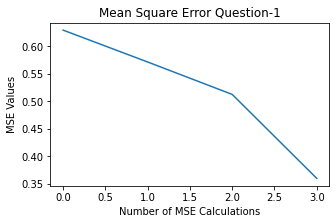

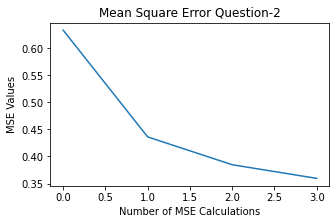

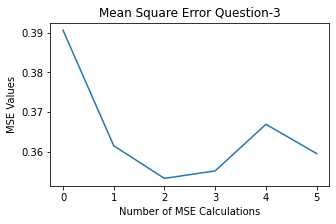

In [155]:
import matplotlib.pyplot as plt
Mean_Square_Error_List=[Mean_Square_Error_Q1,Mean_Square_Error_Q2,Mean_Square_Error_Q3]
a=1
for i in Mean_Square_Error_List:
  fig,ax=plt.subplots(figsize=(5,3))
  ax.plot(range(len(i)),i)
  ax.set_ylabel('MSE Values')
  ax.set_xlabel('Number of MSE Calculations')
  ax.set_title('Mean Square Error Question-'+str(a))
  a=a+1
  plt.show()

1-GRAPH: rank=[5, 7, 10, 20],maxIter=20 and datasize=100000.

2-GRAPH: rank=20, maxIter=[2, 5,10, 20] and datasize=100000.

3-GRAPH: rank=20, maxIter=20 and datasize=[2000, 5000, 10000, 20000, 50000, 100000]. 

When we compare these three graphs, we can see that data size affects MSE most significantly; the second parameter which affects MSE most is the number of iterations; the less effective one is the rank. All three of them reached the same MSE values because, in the last iteration, all the parameter values were the same for all three questions; rank=20, maxIter=20, and datasize=100000. However, data size gave the lowest MSE


